In [1]:
from google.colab import files
uploaded = files.upload()


Saving yahoo_SPX.csv to yahoo_SPX.csv
Saving yahoo_NDX.csv to yahoo_NDX.csv
Saving yahoo_ETH.csv to yahoo_ETH.csv
Saving yahoo_DJIA.csv to yahoo_DJIA.csv
Saving yahoo_BTC.csv to yahoo_BTC.csv
Saving yahoo_BNB.csv to yahoo_BNB.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

# All features

In [3]:
# Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')
ndx_data = pd.read_csv('yahoo_NDX.csv')

In [4]:
ndx_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,6295.290039,6315.160156,6248.290039,6312.209961,6312.209961,2243500000
1,2017-11-10,6297.149902,6313.169922,6284.220215,6309.069824,6309.069824,1979120000
2,2017-11-13,6286.009766,6325.180176,6285.970215,6316.180176,6316.180176,1976460000
3,2017-11-14,6293.330078,6300.459961,6263.770020,6293.640137,6293.640137,1988230000
4,2017-11-15,6261.270020,6276.799805,6227.990234,6258.359863,6258.359863,1923730000


In [5]:
# Convert the Date column to datetime
for df in [btc_data, eth_data, bnb_data, ndx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [6]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,BNB_Open,BNB_High,BNB_Low,BNB_Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,308.644989,329.451996,307.056000,320.884003,2.05314,2.17423,1.89394,1.99077,6295.290039,6315.160156,6248.290039,6312.209961,2243500000
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,320.670990,324.717987,294.541992,299.252991,2.00773,2.06947,1.64478,1.79684,6297.149902,6313.169922,6284.220215,6309.069824,1979120000
2,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,307.024994,328.415009,307.024994,316.716003,1.52601,1.73502,1.51760,1.68662,6286.009766,6325.180176,6285.970215,6316.180176,1976460000
3,2017-11-14,6561.479980,6764.979980,6461.750000,6635.750000,3197110016,316.763000,340.177002,316.763000,337.631012,1.68928,1.73537,1.56827,1.59258,6293.330078,6300.459961,6263.770020,6293.640137,1988230000
4,2017-11-15,6634.759766,7342.250000,6634.759766,7315.540039,4200880128,337.963989,340.911987,329.812988,333.356995,1.58777,1.62498,1.49550,1.53045,6261.270020,6276.799805,6227.990234,6258.359863,1923730000


In [7]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [8]:
# GRU model
model = Sequential()
model.add(GRU(units=32, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9645 - val_loss: 1.0645
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7892 - val_loss: 0.8000
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6865 - val_loss: 0.6494
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6578 - val_loss: 0.6184
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6277 - val_loss: 0.6164
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6173 - val_loss: 0.5905
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5938 - val_loss: 0.5918
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5814 - val_loss: 0.5614
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5639 - val_loss: 0.5557
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5528 - val_loss: 0.5354
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5397 - val_loss: 0.5200
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [10]:

# Create a placeholder for inverse transformation
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler.inverse_transform(actual_ndx_full)[:, -2]

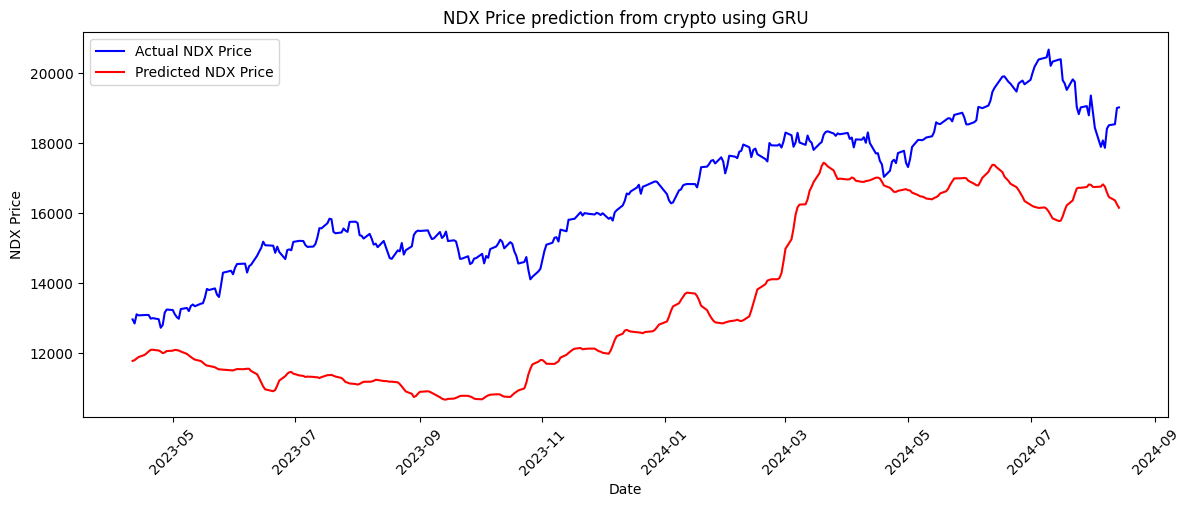

In [11]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('NDX Price prediction from crypto using GRU')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()


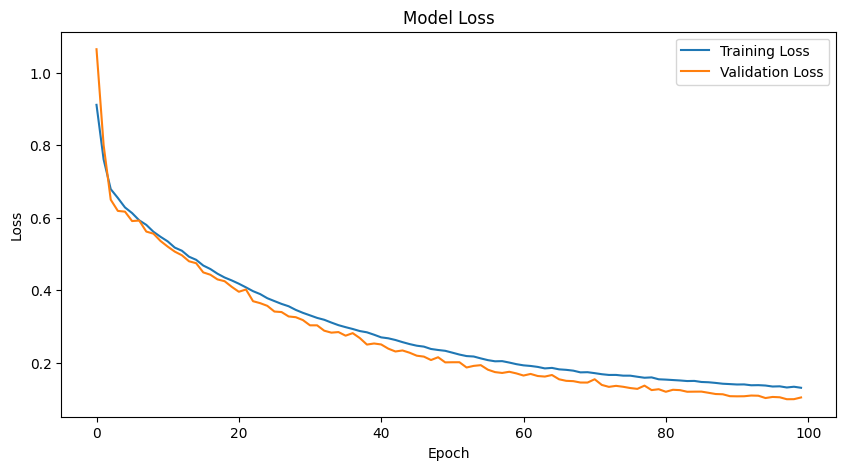

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Prediction of SPX stock prices

### Only one feature: Closing Price

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# All features

In [14]:
# Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
spx_data = pd.read_csv('yahoo_SPX.csv')

In [15]:
# Convert the Date column to datetime
for df in [btc_data, eth_data, bnb_data, spx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))


In [16]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,BNB_Open,BNB_High,BNB_Low,BNB_Close,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,308.644989,329.451996,307.056000,320.884003,2.05314,2.17423,1.89394,1.99077,2584.000000,2586.500000,2566.330078,2584.620117,3844100000
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,320.670990,324.717987,294.541992,299.252991,2.00773,2.06947,1.64478,1.79684,2580.179932,2583.810059,2575.570068,2582.300049,3489740000
2,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,307.024994,328.415009,307.024994,316.716003,1.52601,1.73502,1.51760,1.68662,2576.530029,2587.659912,2574.479980,2584.840088,3405200000
3,2017-11-14,6561.479980,6764.979980,6461.750000,6635.750000,3197110016,316.763000,340.177002,316.763000,337.631012,1.68928,1.73537,1.56827,1.59258,2577.750000,2579.659912,2566.560059,2578.870117,3643580000
4,2017-11-15,6634.759766,7342.250000,6634.759766,7315.540039,4200880128,337.963989,340.911987,329.812988,333.356995,1.58777,1.62498,1.49550,1.53045,2569.449951,2572.840088,2557.449951,2564.620117,3586590000


In [17]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [18]:
# GRU model
model = Sequential()
model.add(GRU(units=32, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7929 - val_loss: 0.7092
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7108 - val_loss: 0.6628
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6745 - val_loss: 0.6377
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6533 - val_loss: 0.6230
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6302 - val_loss: 0.6125
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6148 - val_loss: 0.5968
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5879 - val_loss: 0.5807
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5679 - val_loss: 0.5588
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5548 - val_loss: 0.5550
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5417 - val_loss: 0.5467
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5260 - val_loss: 0.5170
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [20]:
# Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler.inverse_transform(actual_spx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values


In [21]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,BNB_Open,BNB_High,BNB_Low,BNB_Close,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,308.644989,329.451996,307.056000,320.884003,2.05314,2.17423,1.89394,1.99077,2584.000000,2586.500000,2566.330078,2584.620117,3844100000
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,320.670990,324.717987,294.541992,299.252991,2.00773,2.06947,1.64478,1.79684,2580.179932,2583.810059,2575.570068,2582.300049,3489740000
2,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,307.024994,328.415009,307.024994,316.716003,1.52601,1.73502,1.51760,1.68662,2576.530029,2587.659912,2574.479980,2584.840088,3405200000
3,2017-11-14,6561.479980,6764.979980,6461.750000,6635.750000,3197110016,316.763000,340.177002,316.763000,337.631012,1.68928,1.73537,1.56827,1.59258,2577.750000,2579.659912,2566.560059,2578.870117,3643580000
4,2017-11-15,6634.759766,7342.250000,6634.759766,7315.540039,4200880128,337.963989,340.911987,329.812988,333.356995,1.58777,1.62498,1.49550,1.53045,2569.449951,2572.840088,2557.449951,2564.620117,3586590000


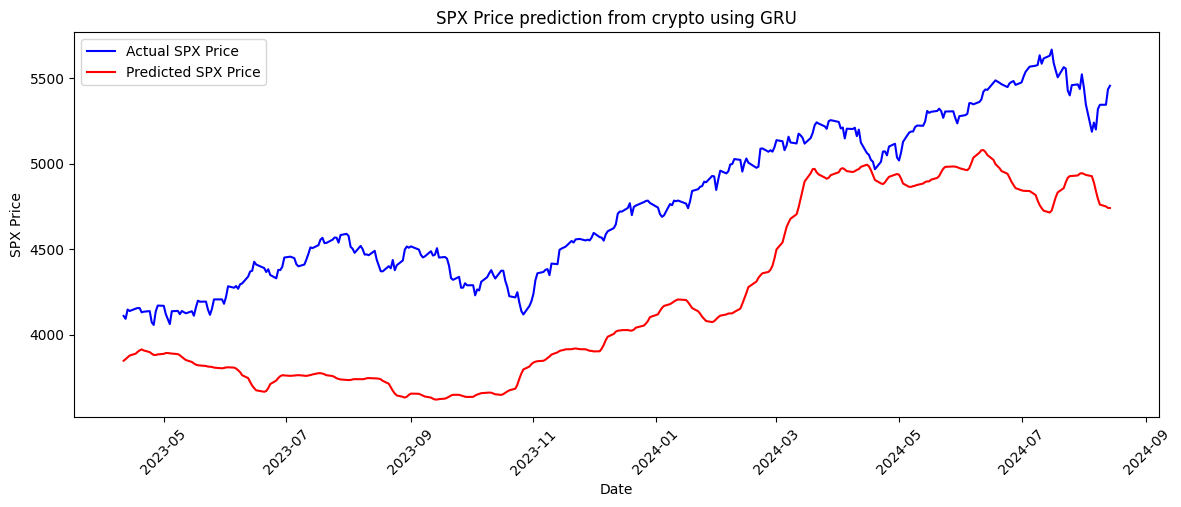

In [22]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('SPX Price prediction from crypto using GRU')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

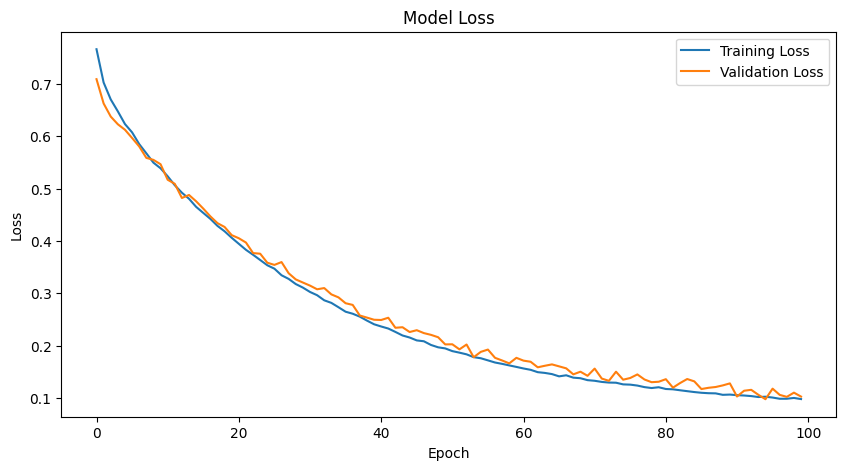

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# DOW JONES INDUSTRIAL AVG

In [24]:
# Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
dow_data = pd.read_csv('yahoo_DJIA.csv')


In [25]:
# Convert the Date column to datetime
for df in [btc_data, bnb_data, eth_data, dow_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    dow_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close', 'Volume': 'DOW_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [26]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except DOW variables
        y = data[i+sequence_length, -2]  # Target is DOW_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [27]:
# GRU model
model = Sequential()
model.add(GRU(units=32, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9200 - val_loss: 0.9420
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8069 - val_loss: 0.8057
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7454 - val_loss: 0.7665
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7092 - val_loss: 0.7259
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6742 - val_loss: 0.7220
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6459 - val_loss: 0.6942
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6246 - val_loss: 0.6749
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5993 - val_loss: 0.6654
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5814 - val_loss: 0.6504
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5704 - val_loss: 0.6381
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5503 - val_loss: 0.6273
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [29]:
# Create a placeholder for inverse transformation
predicted_dow_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_dow_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the DOW_Close column)
predicted_dow_full[:, -2] = predictions[:, 0]
actual_dow_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_dow = scaler.inverse_transform(predicted_dow_full)[:, -2]
actual_dow = scaler.inverse_transform(actual_dow_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values


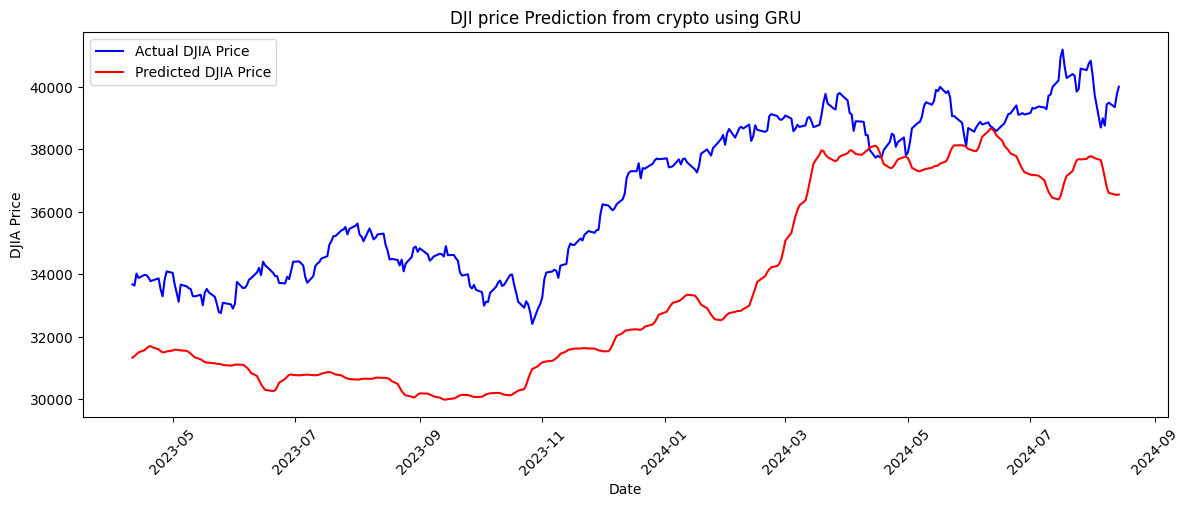

In [30]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_dow, color='blue', label='Actual DJIA Price')
plt.plot(test_dates, predicted_dow, color='red', label='Predicted DJIA Price')
plt.title('DJI price Prediction from crypto using GRU')
plt.xlabel('Date')
plt.ylabel('DJIA Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

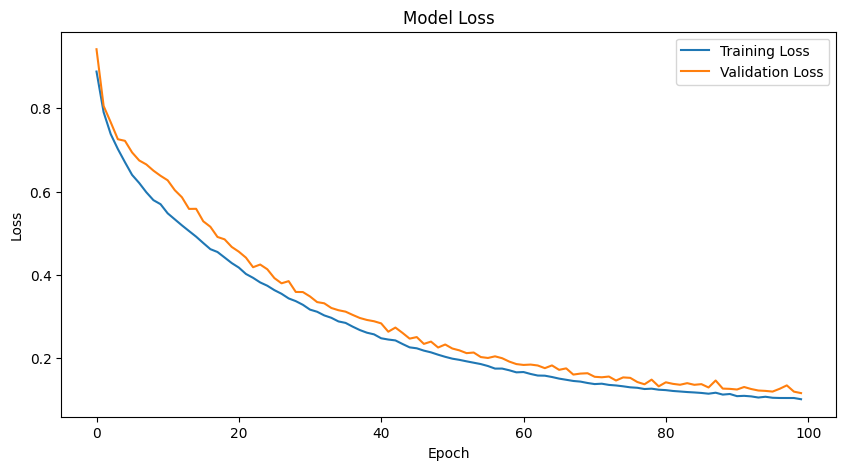

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()